In [21]:
## Version futuresales lib required = 0.1.11

!pip install -i https://test.pypi.org/simple/ futuresales_denissimo==0.1.11
# !pip install plotly==5.3.1
# !pip install neptune-client
# !pip install neptune-sklearn

Looking in indexes: https://test.pypi.org/simple/


In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import futuresales as fs

from futuresales.distribution import from_pickle, to_pickle
from futuresales.utils import make_scaled, load_credentials
from futuresales.validation import Validator, causation_1_percent
from neptune.new.types import File

import seaborn as sns

In [23]:
RUN_NAME = 'FSRES-28'

In [24]:
import neptune.new as neptune

cred = load_credentials('../../credentials.json')['projects']['fs-results']

run = neptune.init(
    api_token=cred['api_token'],
    project=cred['project'],
    run=RUN_NAME
)  # your credentials

https://app.neptune.ai/denissimo/FS-Results/e/FSRES-28
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [25]:
task_df = {}

idx = pd.read_csv('../../tmp/idx.csv').rename({'id': 'object_id'}, axis=1)

task_df['test'] = pd.read_csv('../../tmp/task_df_test.csv').drop('Unnamed: 0', axis=1)
task_df['dynamic'] = from_pickle('../../tmp/id_sales_test.pkl')

In [26]:
run['dump/residuals'].download()
report = from_pickle('./residuals.pkl')
report['object_id'] = task_df['dynamic'].index
report['residuals'] = report['predicted'] - report['valid_target']

In [27]:
report

,valid_target,residuals,predicted,object_id
0,0.0,0.155878,0.155878,54
1,0.0,0.155487,0.155487,114
2,0.0,0.169894,0.169894,174
3,0.0,0.151386,0.151386,234
4,0.0,0.142841,0.142841,294
...,...,...,...,...
422572,0.0,0.140904,0.140904,1330036
422573,0.0,0.087859,0.087859,1330090
422574,0.0,0.104583,0.104583,1330142
422575,0.0,0.084865,0.084865,1330150


In [28]:
report = report.merge(idx, on='object_id', how='left')

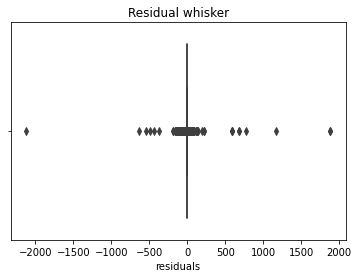

In [29]:
run['analysis/residuals/plots/whisker'].upload(File.as_image(sns.boxplot(data=report, x='residuals').set_title('Residual whisker').figure))

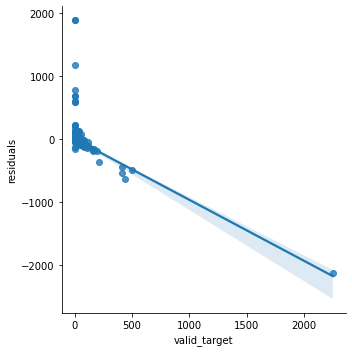

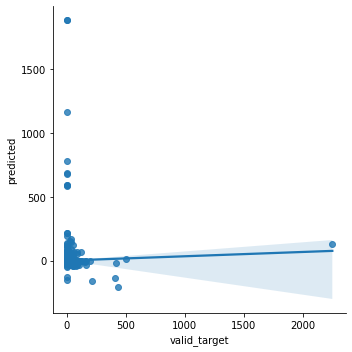

In [30]:
run['analysis/residuals/plots/dependecies'] = {
    'target_residual': File.as_image(sns.lmplot(data=report, x='valid_target', y='residuals').figure),
    'target_predicted': File.as_image(sns.lmplot(data=report, x='valid_target', y='predicted').figure),
}

In [31]:
stable_residual_interval = report.reset_index().rename(columns={'index': 'id'}).merge(idx)
stable_residual_interval['abs_residuals'] = abs(stable_residual_interval['residuals'])

In [32]:
giant_test, percent_str =  causation_1_percent(stable_residual_interval)

0.1% of objects cause 0.983991693764773 of error


In [33]:
giant_test

,id,valid_target,residuals,predicted,object_id,Unnamed: 0,item_name,item_id,item_category_id,shop_name,shop_id,item_category_name,abs_residuals,part
35784,35784,19.0,-18.889981,0.110019,101431,101431,ЗЕМЛЯ БУДУЩЕГО,11703,40,"Москва ТЦ ""Семеновский""",31,Кино - DVD,18.889981,0.000020
344684,344684,2.0,18.901278,20.901278,1071173,1071173,"FIFA 16 [PS4, русская версия]",3351,20,"Уфа ТЦ ""Семья"" 2",53,Игры - PS4,18.901278,0.000020
342811,342811,19.0,-18.909964,0.090036,1068015,1068015,Assassin's Creed: Синдикат. Специальное издани...,1583,20,"Калуга ТРЦ ""XXI век""",15,Игры - PS4,18.909964,0.000020
199133,199133,2.0,18.910224,20.910224,519995,519995,"Mad Max [PC, Jewel, русские субтитры]",4719,30,"Н.Новгород ТРЦ ""Фантастика""",35,Игры PC - Стандартные издания,18.910224,0.000020
118128,118128,19.0,-18.920326,0.079674,339505,339505,DEL REY LANA Honeymoon,2576,55,"Москва ТРК ""Атриум""",25,Музыка - CD локального производства,18.920326,0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419944,419944,0.0,776.550952,776.550952,1316815,1316815,"Билет ""ИгроМир 2015"" - 2 октября 2015 УПР [Циф...",9247,8,Цифровой склад 1С-Онлайн,55,Билеты (Цифра),776.550952,0.033030
419946,419946,0.0,1167.225555,1167.225555,1316935,1316935,"Билет ""ИгроМир 2015"" - 3 октября 2015 УПР [Циф...",9251,8,Цифровой склад 1С-Онлайн,55,Билеты (Цифра),1167.225555,0.074624
419945,419945,0.0,1882.394045,1882.394045,1316875,1316875,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",9249,8,Цифровой склад 1С-Онлайн,55,Билеты (Цифра),1882.394045,0.194083
419983,419983,0.0,1882.506782,1882.506782,1317192,1317192,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",9248,80,Интернет-магазин ЧС,12,Служебные - Билеты,1882.506782,0.194106


In [34]:
run['analysis/residuals/top_worst/magic_string'] = percent_str
run['analysis/residuals/top_worst/raw_giants'].upload(File.as_pickle(giant_test))


serieses = task_df['test'].groupby(['month_block', 'id']).item_cnt_day.sum().reset_index().set_index('id').index.value_counts().reset_index().rename({'id': 'appearence', 'index': 'id'}, axis=1)

In [35]:
top_50 = (giant_test.sort_values('part').reset_index()
    .groupby([
        'object_id', 'shop_id', 'item_id', 'shop_name', 'item_name'])
    .agg({
        'predicted': [np.mean],
        'valid_target': [np.mean], 
        'part': [np.mean], 
        'abs_residuals': [np.mean, lambda x: np.mean(x)**2]})
    .sort_values(('part', 'mean'))
    .tail(50)
    )
run['analysis/residuals/top_worst/top_50_objects'].upload(File.as_html(top_50))

In [36]:
top_15_shops = (giant_test.sort_values('part')
    .groupby([
        'shop_id', 'shop_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))
run['analysis/residuals/top_worst/top_15_shops'].upload(File.as_html(top_15_shops))

In [37]:
top_15_items= (giant_test.sort_values('part')
    .groupby([
        'item_id', 'item_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))
run['analysis/residuals/top_worst/top_15_items'].upload(File.as_html(top_15_items))

In [38]:
top_50.reset_index().set_index('object_id')

shop_id item_id                        shop_name  \
                                                             
object_id                                                    
1317268        28    9250  Москва ТЦ "МЕГА Теплый Стан" II   
1244527         7   20949           Воронеж ТРЦ "Максимир"   
519969          9    4719                Выездная Торговля   
1076125        25    7224              Москва ТРК "Атриум"   
1244534        14   20949          Казань ТЦ "ПаркХаус" II   
528429          9    7018                Выездная Торговля   
1244542        22   20949               Москва Магазин С21   
1266355        55    7967         Цифровой склад 1С-Онлайн   
1076905        25   10202              Москва ТРК "Атриум"   
525789          9    6503                Выездная Торговля   
1317391        31    9254          Москва ТЦ "Семеновский"   
1244524         4   20949         Волжский ТЦ "Волга Молл"   
1071151        31    3351          Москва ТЦ "Семеновский"   
1071266        26    3445      Москва ТЦ "Ареал" (Беляево)   
1076922        42   10202           СПб ТК "Невский Центр"   
1244566        46   20949            Сергиев Посад ТЦ "7Я"   
1317266        26    9250      Москва ТЦ "Ареал" (Беляево)   
1321220        20   13246              Москва "Распродажа"   
1244576        56   20949             Чехов ТРЦ "Карнавал"   
1287849         9   16843                Выездная Торговля   
1317151        31    9246          Москва ТЦ "Семеновский"   
1071162        42    3351           СПб ТК "Невский Центр"   
1244547        27   20949   Москва ТЦ "МЕГА Белая Дача II"   
1071145        25    3351              Москва ТРК "Атриум"   
1317385        25    9254              Москва ТРК "Атриум"   
1244577        57   20949          Якутск Орджоникидзе, 56   
1065282        42   10201           СПб ТК "Невский Центр"   
1244574        54   20949                  Химки ТЦ "Мега"   
1065265        25   10201              Москва ТРК "Атриум"   
1244541        21   20949           Москва МТРЦ "Афи Молл"   
1244567        47   20949           Сургут ТРЦ "Сити Молл"   
1317271        31    9250          Москва ТЦ "Семеновский"   
900009          9    4201                Выездная Торговля   
1317265        25    9250              Москва ТРК "Атриум"   
1317145        25    9246              Москва ТРК "Атриум"   
1244548        28   20949  Москва ТЦ "МЕГА Теплый Стан" II   
1244562        42   20949           СПб ТК "Невский Центр"   
1244532        12   20949              Интернет-магазин ЧС   
1244551        31   20949          Москва ТЦ "Семеновский"   
1317055        55    9255         Цифровой склад 1С-Онлайн   
1316995        55    9253         Цифровой склад 1С-Онлайн   
1317312        12    9252              Интернет-магазин ЧС   
1244545        25   20949              Москва ТРК "Атриум"   
1317072        12    9244              Интернет-магазин ЧС   
1316755        55    9245         Цифровой склад 1С-Онлайн   
1316815        55    9247         Цифровой склад 1С-Онлайн   
1316935        55    9251         Цифровой склад 1С-Онлайн   
1316875        55    9249         Цифровой склад 1С-Онлайн   
1317192        12    9248              Интернет-магазин ЧС   
1317972        12   11373              Интернет-магазин ЧС   

                                                   item_name    predicted  \
                                                                     mean   
object_id                                                                   
1317268    Билет "ИгроМир 2015" - 3 октября 2015 [Цифрова...    84.385416   
1244527    Фирменный пакет майка 1С Интерес белый (34*42)...   -26.702949   
519969                 Mad Max [PC, Jewel, русские субтитры]     0.103753   
1076125    Uncharted: Натан Дрейк. Коллекция. Специальное...     0.087890   
1244534    Фирменный пакет майка 1С Интерес белый (34*42)...   -23.042614   
528429                        Titanfall [PC, русская версия]    -4.398434   
1244542    Фирменный пакет май

{1316935, 1317192, 1316875, 1316815, 1317972}
{1317312, 1244545, 1316995, 1317072, 1316755}
{1244548, 1244551, 1244562, 1244532, 1317055}
{1244567, 900009, 1317265, 1317271, 1317145}
{1244577, 1065282, 1065265, 1244541, 1244574}
{1244547, 1071145, 1317385, 1071162, 1317151}
{1244576, 1321220, 1287849, 1317266, 1244566}
{1071266, 1244524, 1317391, 1071151, 1076922}
{1076905, 528429, 1266355, 525789, 1244542}
{519969, 1244527, 1317268, 1244534, 1076125}


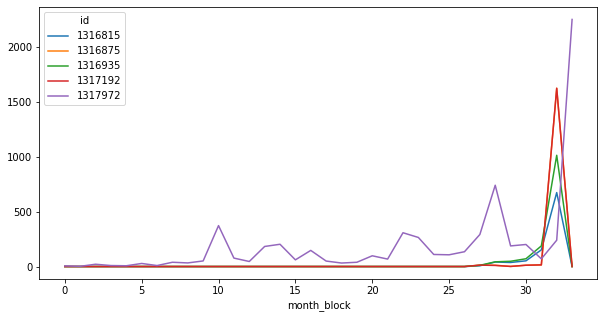

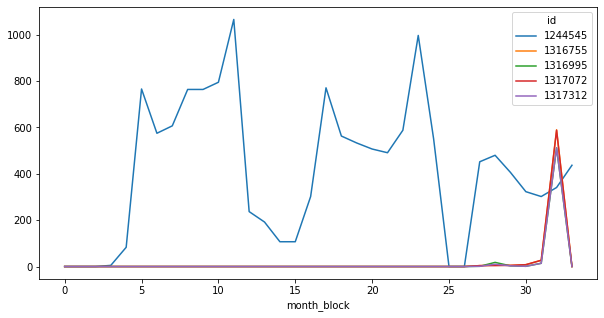

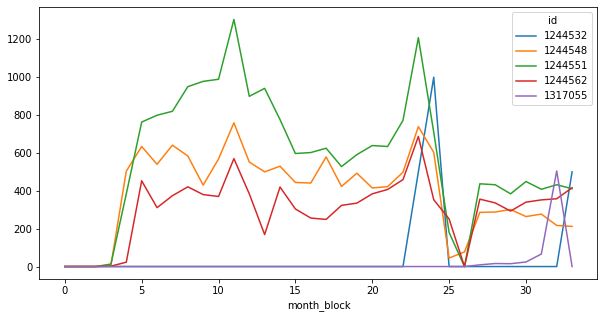

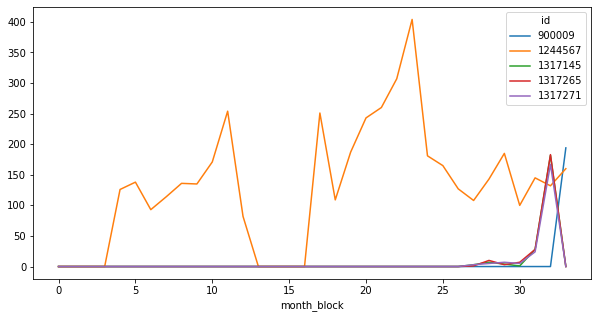

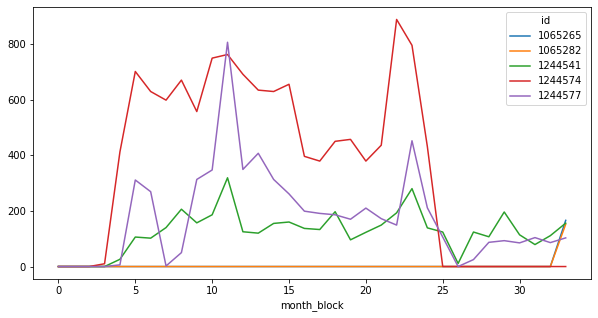

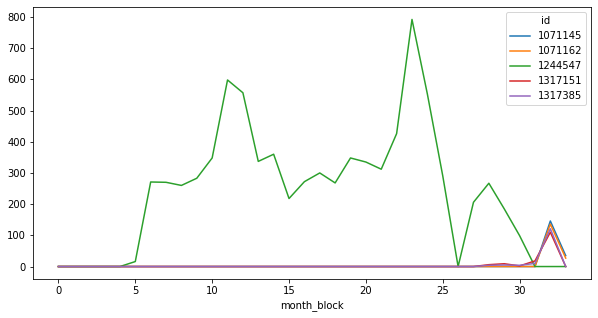

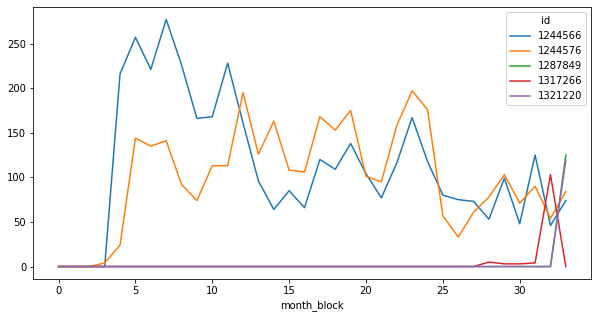

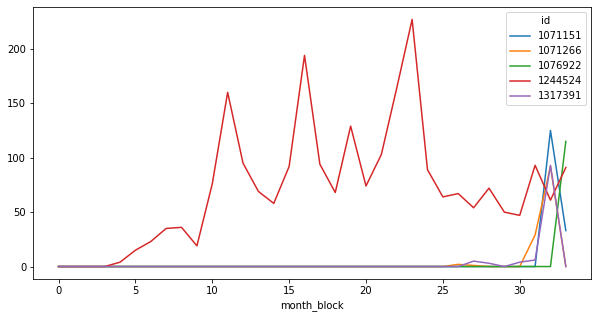

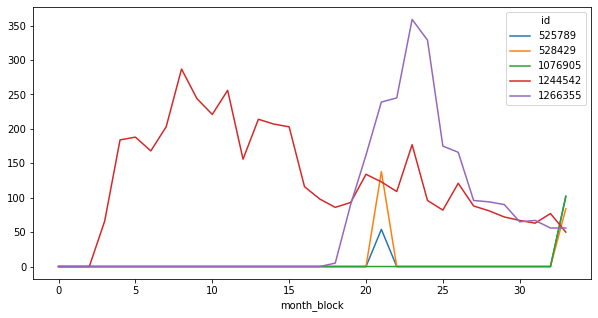

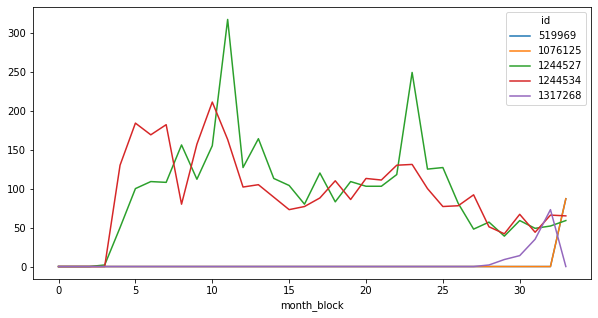

In [39]:
for i in range(0, 10):
    id_slice = top_50.reset_index().set_index('object_id').index.to_list()[-5 - 5*i: -5 - 5*(i - 1)] if i != 0 else top_50.reset_index().set_index('object_id').index.to_list()[-5: None]
    print(set(id_slice) & set(task_df['dynamic'].index))
    fig = task_df['dynamic'][task_df['dynamic'].index.isin(id_slice)].transpose().plot(figsize=(10, 5)).figure
    run[f'analysis/residuals/plots/top_{5*i}-{5*(i + 1)}_items'].upload(File.as_image(fig))

In [40]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 40 operations to synchronize with Neptune. Do not kill this process.


All 40 operations synced, thanks for waiting!
